In [1]:
import os
import sys
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics, ensemble
import lightgbm as lgb

In [2]:
data_dir = 'data/'
print("Data Files are: ", os.listdir(data_dir))
train = pd.read_csv(data_dir + 'train.csv')
test = pd.read_csv(data_dir + 'test.csv')
print("Train DataFrame Shape: ", train.shape)
print("Test DataFrame Shape: ", test.shape)
train.head()

Data Files are:  ['sample_submission.csv.zip', 'test.csv', 'test.csv.zip', 'train.csv', 'train.csv.zip']
Train DataFrame Shape:  (4459, 4993)
Test DataFrame Shape:  (49342, 4992)


,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


# Leaks in the Dataset

There exists leaks in the dataset as the columns and rows are both time-seires. The analysis are at:

Giba's Property:

https://www.kaggle.com/titericz/the-property-by-giba (kernel)

https://www.kaggle.com/c/santander-value-prediction-challenge/discussion/61329 (post)

And the analysis result used is at:

https://www.kaggle.com/johnfarrell/giba-s-property-extended-extended-result

https://www.kaggle.com/johnfarrell/breaking-lb-fresh-start-with-lag-selection

https://www.kaggle.com/johnfarrell/baseline-with-lag-select-fake-rows-dropped

In [3]:
#Row indexes(36)
row_l_index = [1757, 3809, 511, 3798, 625, 3303, 4095, 1283, 4209, 1696, 3511, 816, 245, 1383, 2071, 3492, 378, 2971, 
               2366, 4414, 2790, 3979, 193, 1189, 3516, 810, 4443, 3697, 235, 1382, 4384, 3418, 4396, 921, 3176, 650]

#Column indexes(40)
col_l_index = ['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', '15ace8c9f', 'fb0f5dbfe', '58e056e12',
               '20aa07010', '024c577b9', 'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', '62e59a501', 
               '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', 
               '1931ccfdd', '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', '6619d81fc', '1db387535', 
               'fc99f9426', '91f701ba2', '0572565c2', '190db8488', 'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98']

train.loc[row_l_index, col_l_index]

,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,20aa07010,024c577b9,...,6619d81fc,1db387535,fc99f9426,91f701ba2,0572565c2,190db8488,adb64ff71,c47340d97,c5a231d81,0ff32eb98
1757,1015000.00,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
3809,540000.00,1015000.00,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
511,115636.36,540000.00,1015000.00,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
3798,834800.00,115636.36,540000.00,1015000.00,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
625,296444.44,834800.00,115636.36,540000.00,1015000.00,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
3303,247166.66,296444.44,834800.00,115636.36,540000.00,1015000.00,1563411.76,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
4095,550000.00,247166.66,296444.44,834800.00,115636.36,540000.00,1015000.00,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
1283,440000.00,3076666.66,550000.00,247166.66,296444.44,834800.00,115636.36,540000.00,1015000.00,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
4209,0.00,440000.00,3076666.66,550000.00,247166.66,296444.44,834800.00,115636.36,540000.00,1015000.00,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
1696,1600000.00,0.00,440000.00,3076666.66,550000.00,247166.66,296444.44,834800.00,115636.36,540000.00,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76


# Data Analysis
## Visualize data distribution

In [4]:
train = train[train.columns.drop(col_l_index)]

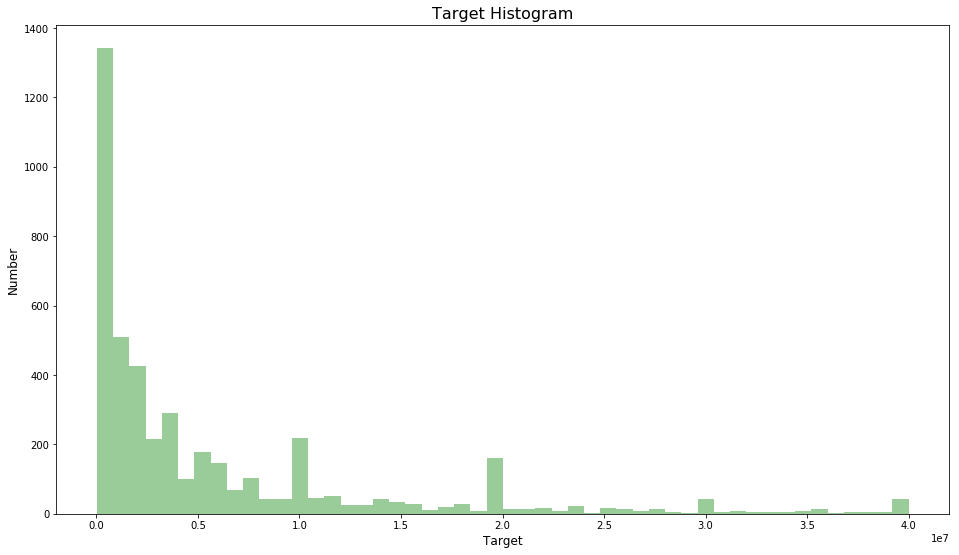

In [5]:
plt.figure(figsize=(16, 9))
sns.distplot(train["target"].values, bins=50, kde=False, color='g')
plt.xlabel('Target', fontsize=12)
plt.ylabel('Number', fontsize=12)
plt.title("Target Histogram", fontsize=16)
plt.show()

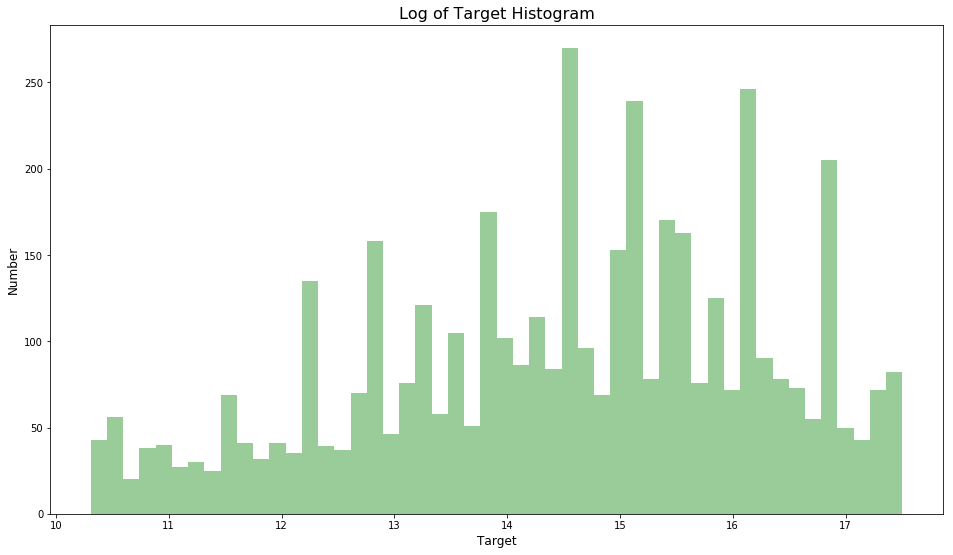

In [6]:
plt.figure(figsize=(16, 9))
sns.distplot(np.log(train["target"].values), bins=50, kde=False, color='g')
plt.xlabel('Target', fontsize=12)
plt.ylabel('Number', fontsize=12)
plt.title("Log of Target Histogram", fontsize=16)
plt.show()

In [7]:
# Print data type of each column
datatype = train.dtypes.reset_index()
datatype.groupby(0).aggregate('count')

,index
0,
int64,3147
float64,1805
object,1


In [8]:
# Detect columns with the constant value and drop them
uni_train = train.nunique().reset_index()
uni_train.columns = ["col", "uni_count"]
const_train = uni_train[uni_train["uni_count"] == 1]
const_train.shape
const_name = const_train.col.tolist()
train = train[train.columns.drop(const_name)]

## Calculate data Correlation

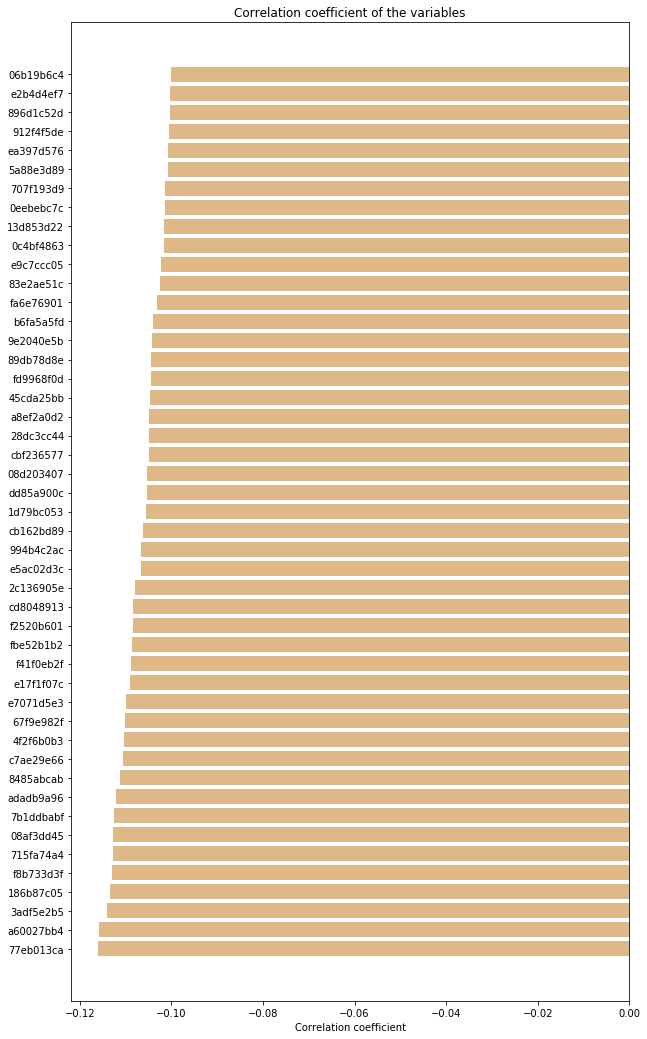

In [9]:
# Calculate spearman correlation between features and targets, plot and delete larger ones
from scipy.stats import spearmanr

correlation = [spearmanr(train['target'], train[c])[0] for c in train.columns.tolist()[2:]]
corr = pd.DataFrame({'col_name': train.columns.tolist()[2:], 'col_values': correlation}).sort_values(by='col_values')

corr = corr[(corr['col_values']>0.1) | (corr['col_values']<-0.1)]
ind = np.arange(corr.shape[0])
width = 0.9
fig, axes = plt.subplots(figsize=(10,18))
rects = axes.barh(ind, np.array(corr.col_values.values), color='burlywood')
axes.set_yticks(ind)
axes.set_yticklabels(corr.col_name.values, rotation='horizontal')
axes.set_xlabel("Correlation coefficient")
axes.set_title("Correlation coefficient of the variables")
plt.show()

In [10]:
train = train[train.columns.drop(corr.col_name.tolist())]

## Calculate data Importance
#### Using RMSLE and LGBM

In [11]:
x_train = train[train.columns.tolist()[2:]]
y_train = np.log1p(train['target'])
x_test = test[test.columns.tolist()[1:]]

In [12]:
# Use RMSLE to analysis the feature importance from the log target value
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(x_train, y_train)

# Visualization
features = x_train.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indx = np.argsort(importances)[::-1][:20]

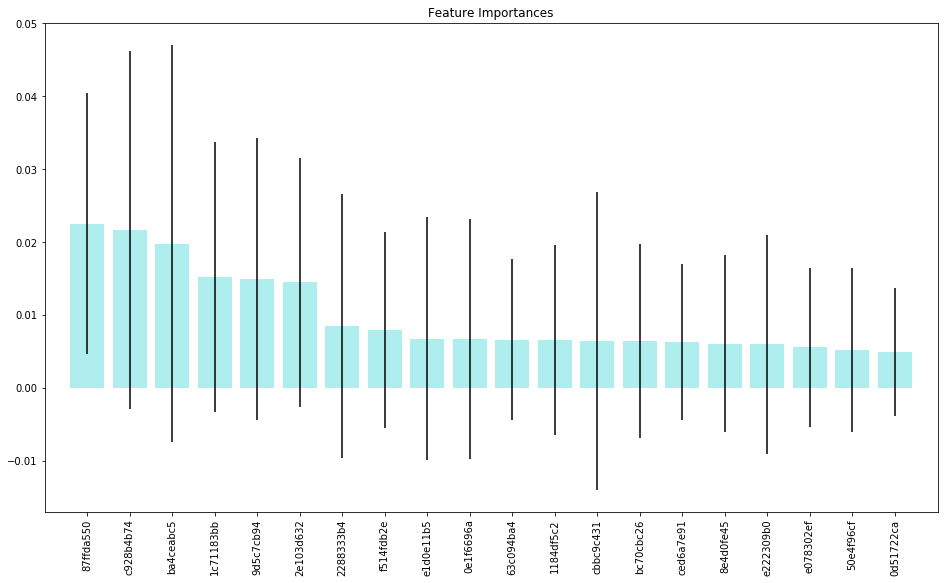

In [13]:
plt.figure(figsize=(16,9))
plt.title("Feature Importances")
plt.bar(range(len(indx)), importances[indx], color="#afeeee", yerr=std[indx], align="center")
plt.xticks(range(len(indx)), features[indx], rotation='vertical')
plt.xlim([-1, len(indx)])
plt.show()

In [19]:
# LGBM feature importance analysis
def lgb_model(x_train, x_test, y_train, y_test):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.8,
        "feature_fraction" : 0.8,
        "bagging_frequency" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "max_depth" : 7
    }
    train = lgb.Dataset(x_train, label=y_train)
    test = lgb.Dataset(x_test, label=y_test)
    model = lgb.train(params, train, 1000, valid_sets=[test], early_stopping_rounds=100, verbose_eval=200)
    return model

In [20]:
# Use KFold cross validation and average prediction of the test set
split = 5
kf = model_selection.KFold(n_splits=split, shuffle=True, random_state=42)
for t_idx, v_idx in kf.split(x_train):
    t_x, v_x = x_train.loc[t_idx,:], x_train.loc[v_idx,:]
    t_y, v_y = y_train[t_idx], y_train[v_idx]
    model = lgb_model(t_x, v_x, t_y, v_y)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.52476
[400]	valid_0's rmse: 1.49137
[600]	valid_0's rmse: 1.47825
[800]	valid_0's rmse: 1.47472
[1000]	valid_0's rmse: 1.47272
Did not meet early stopping. Best iteration is:
[987]	valid_0's rmse: 1.47245
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.58962
[400]	valid_0's rmse: 1.54771
[600]	valid_0's rmse: 1.53189
[800]	valid_0's rmse: 1.52201
[1000]	valid_0's rmse: 1.51551
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.51551
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.5676
[400]	valid_0's rmse: 1.52324
[600]	valid_0's rmse: 1.51229
[800]	valid_0's rmse: 1.50574
[1000]	valid_0's rmse: 1.50284
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 1.50282
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.54525
[400]	valid_0's rmse: 1.496
[60

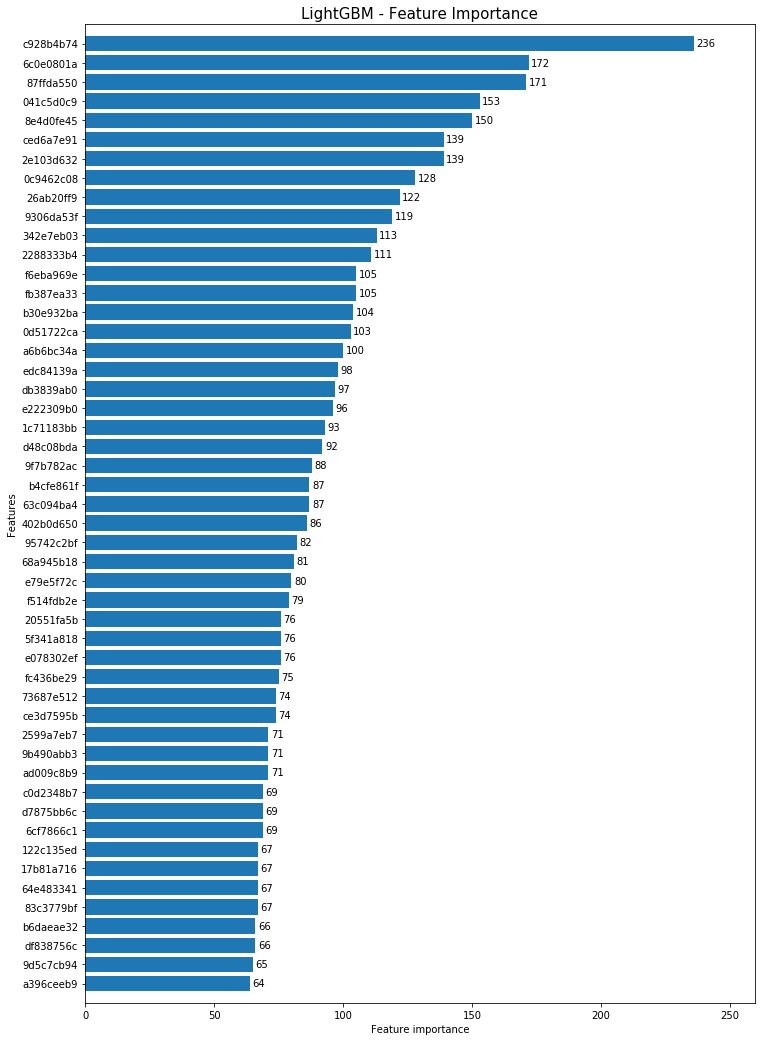

In [21]:
# Plot Feature Importances
fig, axes = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=axes)
axes.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [17]:
features[np.argsort(importances)[::-1][:20]]

array(['87ffda550', 'c928b4b74', 'ba4ceabc5', '1c71183bb', '9d5c7cb94',
       '2e103d632', '2288333b4', 'f514fdb2e', 'e1d0e11b5', '0e1f6696a',
       '63c094ba4', '1184df5c2', 'cbbc9c431', 'bc70cbc26', 'ced6a7e91',
       '8e4d0fe45', 'e222309b0', 'e078302ef', '50e4f96cf', '0d51722ca'],
      dtype=object)

In [22]:
importance = model.feature_importance()
feature_name = model.feature_name()
tuples = sorted(zip(feature_name, importance), key=lambda x: x[1])
labels, values = zip(*tuples)
labels[-20:]

('e222309b0',
 'db3839ab0',
 'edc84139a',
 'a6b6bc34a',
 '0d51722ca',
 'b30e932ba',
 'fb387ea33',
 'f6eba969e',
 '2288333b4',
 '342e7eb03',
 '9306da53f',
 '26ab20ff9',
 '0c9462c08',
 '2e103d632',
 'ced6a7e91',
 '8e4d0fe45',
 '041c5d0c9',
 '87ffda550',
 '6c0e0801a',
 'c928b4b74')